# Etude Fake News

Les données sont stockées dans le dossier 'Data', le but de ce travail est de développer une IA capable de reconnaître
les fake news, l'entraîner, la tester et l'amener à la plus haute précision possible.

In [1]:
# Utils libs
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import pyarrow.feather as ft

# AI libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Création du dataset de travail

In [2]:
fake = pd.read_csv('../Data/Fake.csv', delimiter=',')
true = pd.read_csv('../Data/True.csv', delimiter=',')

Nous devons maintenant concaténer ces deux DataFrames pour pouvoir les utiliser en tant qu'une seule et même entité.
Cependant, nous devons être capable de différencier les news fakes et réelles, nous allons donc rajouter une colonne
de booléens 'istrue'.

In [3]:
fake['istrue'] = 0
true['istrue'] = 1

data = true.append(fake)

Nous avons maintenant un DataFrame complet avec les news réelles et fakes, vérifions dimensions et champs.

In [4]:
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,istrue
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Analyse, nettoyage et réparation des données

Maintenant que nous avons le bon dataset, regardons s'il contient des valeurs NULL ou NaN.

In [5]:
print(data.isnull().sum())

title      0
text       0
subject    0
date       0
istrue     0
dtype: int64


Nous nous rendons compte suite à cette exécution qu'aucune valeur NULL ou NaN ne se trouve dans le dataset, nous n'aurons donc pas à réparer les données, ce qui est une bonne nouvelle.
<br>
Nous allons maintenant supprimer la colonne dont nous n'aurons pas besoin dans cette étude : date

In [6]:
data = data.drop(columns='date')
data.head()

,title,text,subject,istrue
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


Cependant, nous allons avoir besoin de séparer les contenus des titres en des chaînes de caractères plus simplifiées pour éviter les confusions durant l'exploitation des données.
<br>
Pour cela, nous aurons besoin des bibliothèques nltk et re, qui contiennent des packages liés aux mots de liaison et aux traitements de chaînes de caractères (notamment le PortStemmer)
<br>
***Stopwords:***
**Un mot de liaison est un mot couramment utilisé (comme "et", "ou", "un", etc) qu'un moteur de recherche a été programmé pour ignorer, que ce soit lors de l'indexation des entrées pour la recherche
ou lors de leur récupération en tant que résultat d'une requête de recherche.
(https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**

***PortStemmer:***
**Un PortStemmer est un algorithme utilisé pour supprimer les terminaisons morphologiques et inflexionnelles les plus courantes des mots.
Par exemple, des mots tels que "Likes", "liked", "likely" et "liking" seront réduits à "like" après le stemming.
(https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)**

In [7]:
titles = np.array(data['title'])

nltk.download('stopwords')

corpustitle = []

for i in range (titles.shape[0]):
    new = re.sub('[^a-zA-Z]', ' ', titles[i])
    # Replaces any string matching the regex with spaces (anything other than a letter)

    new = new.lower()

    new = new.split()

    ps = PorterStemmer()
    new = [ps.stem(word) for word in new if not word in set(stopwords.words('english'))]

    new = ' '.join(new)

    corpustitle.append(new)

data['title'] = corpustitle
data.head()

[nltk_data] Downloading package stopwords to /Users/adute/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,text,subject,istrue
0,u budget fight loom republican flip fiscal script,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,u militari accept transgend recruit monday pen...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,senior u republican senat let mr mueller job,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,fbi russia probe help australian diplomat tip nyt,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,trump want postal servic charg much amazon shi...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


In [40]:
text = np.array(data['text'])

corpustxt = []

for i in range (text.shape[0]):
    new = re.sub('[^a-zA-Z]', ' ', text[i])
    # Replaces any string matching the regex with spaces (anything other than a letter)

    new = new.lower()

    new = new.split()

    ps = PorterStemmer()
    new = [ps.stem(word) for word in new if not word in set(stopwords.words('english'))]

    new = ' '.join(new)

    corpustxt.append(new)

data['text'] = corpustxt
data.head()

,title,text,subject,istrue
0,u budget fight loom republican flip fiscal script,washington reuter head conserv republican fact...,politicsNews,1
1,u militari accept transgend recruit monday pen...,washington reuter transgend peopl allow first ...,politicsNews,1
2,senior u republican senat let mr mueller job,washington reuter special counsel investig lin...,politicsNews,1
3,fbi russia probe help australian diplomat tip nyt,washington reuter trump campaign advis georg p...,politicsNews,1
4,trump want postal servic charg much amazon shi...,seattl washington reuter presid donald trump c...,politicsNews,1


In [41]:
feather = data.reset_index()
ft.write_feather(data, '../Data/datas.feather', compression='zstd')

Maintenant que nos titres sont simplifiés, vectorisons-les en utilisant CountVectorizer
(fourni par sklearn). Puis testons différents modèles (Régression Logistique, Arbre de décision et KNeighbors) d'apprentissage pour en observer les précisions.
<br>
***CountVectorizer:***
**CountVectorizer est un outil fourni par la bibliothèque scikit-learn. Il est utilisé pour transformer
un texte donné en un vecteur sur la base de la fréquence (comptage) de chaque mot qui apparaît
dans le texte entier.
(https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/)**

In [ ]:
data = pd.read_feather('../Data/datas.feather')

countv1 = CountVectorizer(max_features=5000)
Xtitle = countv1.fit_transform(data['title']).toarray()

countv2 = CountVectorizer(max_features=5000)
Xsubject = countv2.fit_transform(data['subject']).toarray()

Les vectorisations ci-dessus n'ont pas été utilisées mais étaient prévues pour des essais, nous les avons délaissées car en faisant le test en prenant seulement le texte en compte on obtenait un résultat plus que satisfaisant, nous n'avions donc pas besoin de tester les autres colonnes (ce qui rallongerait le temps d'éxecution inutilement).
<br>
Nous reprenons donc notre dataframe en le chargeant à partir du fichier feather de sauvegarde.

In [ ]:
data = pd.read_feather('../Data/datas.feather')

0.9974387527839643 85


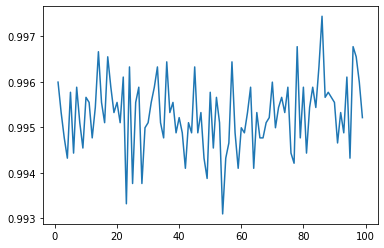

In [9]:
countv = CountVectorizer(max_features=5000)

def print_accuracy(accu_r, acc) :
    plt.plot(accu_r, acc)
    max_accu = max(acc)
    print(max_accu, acc.index(max_accu))

X = countv.fit_transform(data['text']).toarray()
Y = data['istrue'].values

accu_range = range(1, 100)
accu = []
for val in accu_range :
    x_svm_train, x_svm_test, y_svm_train, y_svm_test = train_test_split(X, Y, test_size=0.2, random_state=val)
    regr = LogisticRegression(random_state=val)
    classifier = regr.fit(x_svm_train, y_svm_train)
    y_prediction = classifier.predict(x_svm_test)
    accu.append(accuracy_score(y_svm_test, y_prediction))

print_accuracy(accu_range, accu)

0.9975501113585746 95


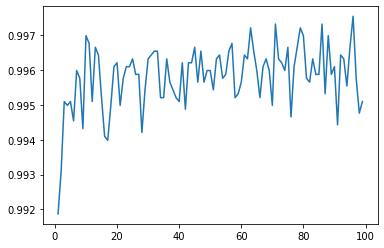

In [7]:
accu = []
for val in accu_range :
    x_svm_train, x_svm_test, y_svm_train, y_svm_test = train_test_split(X, Y, test_size=0.2, random_state=val)
    tree = DecisionTreeClassifier(max_depth=val, random_state=val*10)
    classifier = tree.fit(x_svm_train, y_svm_train)
    y_prediction = classifier.predict(x_svm_test)
    accu.append(accuracy_score(y_svm_test, y_prediction))

print_accuracy(accu_range, accu)

0.8657015590200445 0


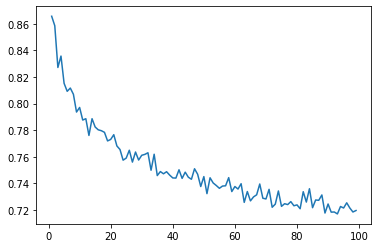

In [8]:
accu = []
for val in accu_range :
    x_svm_train, x_svm_test, y_svm_train, y_svm_test = train_test_split(X, Y, test_size=0.2, random_state=val)
    knn = KNeighborsClassifier(n_neighbors=val)
    classifier = knn.fit(x_svm_train, y_svm_train)
    y_prediction = classifier.predict(x_svm_test)
    accu.append(accuracy_score(y_svm_test, y_prediction))

print_accuracy(accu_range, accu)

Après essais sur chacun des modèles, nous choisissons la régression logistique de par son adaptation au cas présent.
<br>
Dans la cellule suivante, nous ne prendrons en compte que le texte des articles (formaté précédemment) par souci de temps et de besoins physiques (RAM et CPU).<br>
Nous instancions également une liste de timers et une liste d'accuracy pour pouvoir les afficher en tant que graphes.
Après étude des possiblités de modèle les plus efficaces pour notre projet, nous avons choisi la régression logistique.
<br>
Nous effectuerons donc 100 fois, dans l'ordre :
<br>
- Une vectorisation pour obtenir un dictionnaire des mots ayant le plus d'occurrences dans les articles (sa taille variera de 1 à 100)
- Une séparation des données en deux échantillons (train, 80% et test, 20%)
- Le lancement d'un timer
- L'entraînement de l'IA
- L'arrêt du timer
- Le test de l'entraînement de l'IA

Enfin, nous afficherons dans un graphe les résultats des timers et de l'accuracy.

0.9943207126948775 84


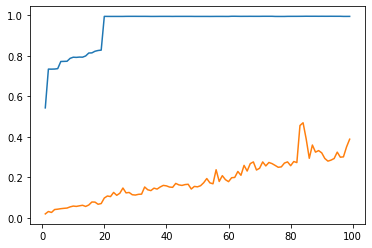

In [7]:
accu = []
accu_range = range(1, 100)
times = []
Y = data['istrue'].values

for i in range(1,100):
    countv = CountVectorizer(max_features=i)
    X2 = countv.fit_transform(data['text']).toarray()
    x_train, x_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=0)
    regr = LogisticRegression(random_state=86)
    start_time = time.time()
    classifier = regr.fit(x_train, y_train)
    times.append(time.time() - start_time)
    y_prediction = classifier.predict(x_test)
    accu.append(accuracy_score(y_test, y_prediction))

print_accuracy(accu_range, accu)
plt.plot(accu_range, times)

Nous obtenons donc ce graphe bidimensionnel. Clarifions le pour plus de compréhension.

Text(0.5, 1.0, "Temps d'entraînement")

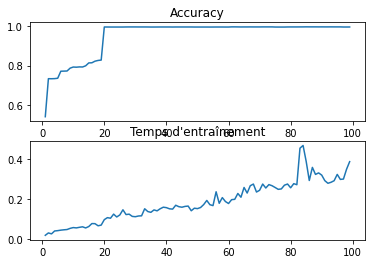

In [9]:
plt.subplot(211)
plt.plot(accu_range, accu)
plt.title("Accuracy")

plt.subplot(212)
plt.plot(accu_range, times)
plt.title("Temps d'entraînement")

Bien, maintenant, nous pouvons observer que la précision du modèle ne subit de changements significatifs qu'entre 0 et 20, ce qui signifie qu'un dictionnaire de taille supérieure à 20 serait sans intérêt.
Nous pouvons également remarquer, sur le deuxième plot, que le temps passé pour l'entraînement de l'IA est similaire à une évolution linéaire. Nous pouvons en conclure qu'une vectorisation avec plus de 20 features se révèlerait inutile et demanderait plus de ressource qu'il n'en faut pour construire une IA performante.
Ce qui nous amène au troisième et dernier point : la précision chiffrée.

In [13]:
max_accu = max(accu)
print(max_accu, " à l'itération n°", accu.index(max_accu))

print(accu[20], " à l'itération n°20")

0.9943207126948775  à l'itération n° 84
0.9935412026726058  à l'itération n°20


On a donc, à l'aide de la régression logistique, établir une précision maximale au tour de boucle n°84, en atteignant 99,43%. Cependant, comme nous l'avons vu, cette précision est très peu fluctuante lorsqu'on dépasse 20, indice pour lequel la précision a atteint 99.35%, très proche du maximum de la liste.